In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
# Load the .mat file
data = sio.loadmat("data/state_patterns_th=0.55_0.6_0.65_0.7_I=5_combined_comm=6_2_new.mat")
#data = sio.loadmat("data/state_patterns_subcircuits_th=0.55_0.6_0.65_0.7_I=5_combined.mat")

# The variable name inside .mat should be 'state'
# Adjust if the variable has a different name
state = data["state"]

# Parameters
num_groups, num_currents, num_thresholds = state.shape
threshold_idx = 1  # <-- choose the threshold index (0-based in Python)

# To store results: a list of arrays for each group
group_union = []

for g in range(num_groups):
    # Collect arrays from all current amplitudes at this threshold
    arrays = []
    for c in range(num_currents):
        cell_content = state[g, c, threshold_idx]
        
        # In MATLAB cell -> Python, these can come as object dtype
        arr = np.array(cell_content)
        if arr.size > 0:  # non-empty
            arrays.append(arr)
    
    if arrays:
        # Concatenate along rows
        group_array = np.vstack(arrays)
    else:
        group_array = np.empty((0, 6))  # empty if nothing
    
    group_union.append(group_array)

# Now group_union[g] is an m×6 numpy array for group g


In [3]:
#for unique patterns
import scipy.io as sio

data = sio.loadmat("data/state_patterns_th=0.55_0.6_0.65_0.7_I=5_combined_comm=6_2_new.mat")
#data = sio.loadmat("data/state_patterns_subcircuits_th=0.55_0.6_0.65_0.7_I=5_combined.mat", squeeze_me=True)
all_vectors = data["state_unique_python"]

# Example: get vectors for threshold=1, group=2
group_union = all_vectors[1]   # depending on shape may be ndarray or object array

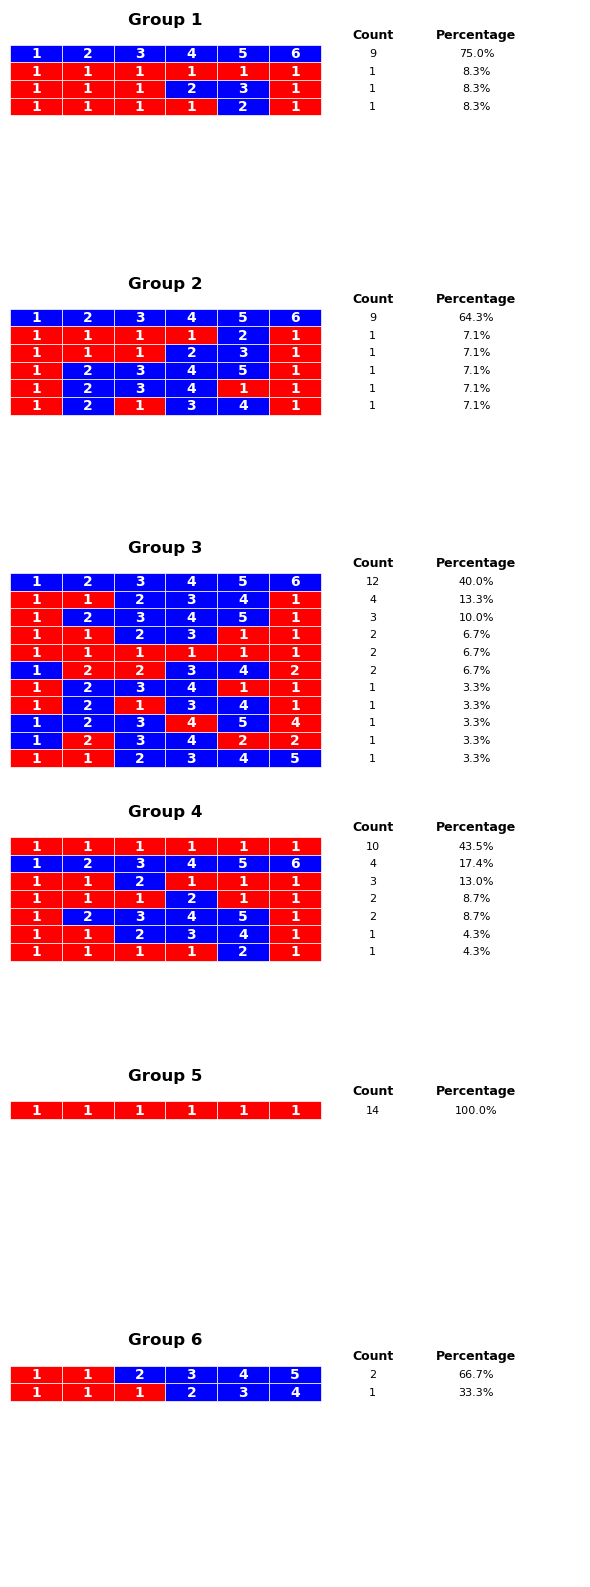

In [4]:
# --- Process a group's array ---
def process_group(arr):
    arr = np.atleast_2d(arr)
    rows = [tuple(row) for row in arr]
    counter = Counter(rows)

    unique_rows = list(counter.keys())
    counts = list(counter.values())
    percentages = [100 * c / len(rows) for c in counts]

    # Sort by percentage (descending)
    sorted_data = sorted(zip(unique_rows, counts, percentages), key=lambda x: -x[2])
    unique_rows, counts, percentages = zip(*sorted_data)

    return unique_rows, counts, percentages


# --- Generate palette for one row ---
def palette_for_row(row):
    row = np.array(row)
    return ["red" if np.sum(row == val) >= 2 else "blue" for val in row]


# --- Display one group ---
def display_group(ax, group_idx, arr, max_rows):
    unique_rows, counts, percentages = process_group(arr)

    # Title
    ax.text(3, 1, f"Group {group_idx+1}", ha="center", va="bottom",
            fontsize=12, weight="bold")

    # Headers
    ax.text(7, 0.2, "Count", ha="center", va="bottom", fontsize=9, weight="bold")
    ax.text(9, 0.2, "Percentage", ha="center", va="bottom", fontsize=9, weight="bold")

    # Draw each row
    for i, (row, count, perc) in enumerate(zip(unique_rows, counts, percentages)):
        y = -(i + 1)  # row position
        palette = palette_for_row(row)

        # Palette with black borders
        for j, (num, col) in enumerate(zip(row, palette)):
            rect = plt.Rectangle((j, y), 1, 1, facecolor=col,
                                 edgecolor="white", linewidth=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, y + 0.5, str(num),
                    ha="center", va="center", color="white",
                    fontsize=10, weight="bold")

        # Count
        ax.text(7, y + 0.5, str(count), ha="center", va="center", fontsize=8)

        # Percentage
        ax.text(9, y + 0.5, f"{perc:.1f}%", ha="center", va="center", fontsize=8)

    # Formatting: fixed height for all groups
    ax.set_xlim(0, 11)
    ax.set_ylim(-max_rows - 1, 2)
    ax.axis("off")


# --- Plot all groups in 2×3 grid ---
max_rows = max(len(process_group(arr)[0]) for arr in group_union)  # largest group length

fig, axes = plt.subplots(num_groups, 1, figsize=(6, 16))
axes = axes.flatten()

for g in range(num_groups):
    display_group(axes[g], g, group_union[g], max_rows)

plt.tight_layout()
plt.show()

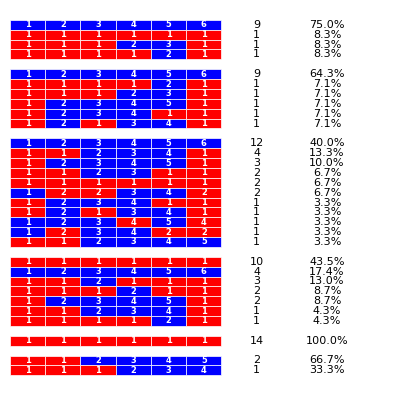

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

y_offset = 0
for g in range(num_groups):
    unique_rows, counts, percentages = process_group(group_union[g])
    for i, (row, count, perc) in enumerate(zip(unique_rows, counts, percentages)):
        y = - (y_offset + i)  # continuous stacking
        palette = palette_for_row(row)
        for j, (num, col) in enumerate(zip(row, palette)):
            rect = plt.Rectangle((j, y), 1, 1, facecolor=col,
                                 edgecolor="white", linewidth=0.5)
            ax.add_patch(rect)
            ax.text(j + 0.5, y + 0.5, str(num),
                    ha="center", va="center", color="white", fontsize=6, weight="bold")
        ax.text(7, y + 0.5, str(count), ha="center", va="center", fontsize=8)
        ax.text(9, y + 0.5, f"{perc:.1f}%", ha="center", va="center", fontsize=8)
    # Add a small gap between groups
    y_offset += len(unique_rows) + 1
    #ax.text(3, - (y_offset - 1.4), f"Group {g+1}", ha="center", va="bottom", fontsize=12, weight="bold")

ax.set_xlim(0, 11)
ax.set_ylim(-y_offset, 2)
ax.axis("off")

plt.savefig("figures/group_palettes_R_th=0.6_unique_sbm_6_2_new.svg", dpi=600, bbox_inches="tight")  # PNG file
plt.show()

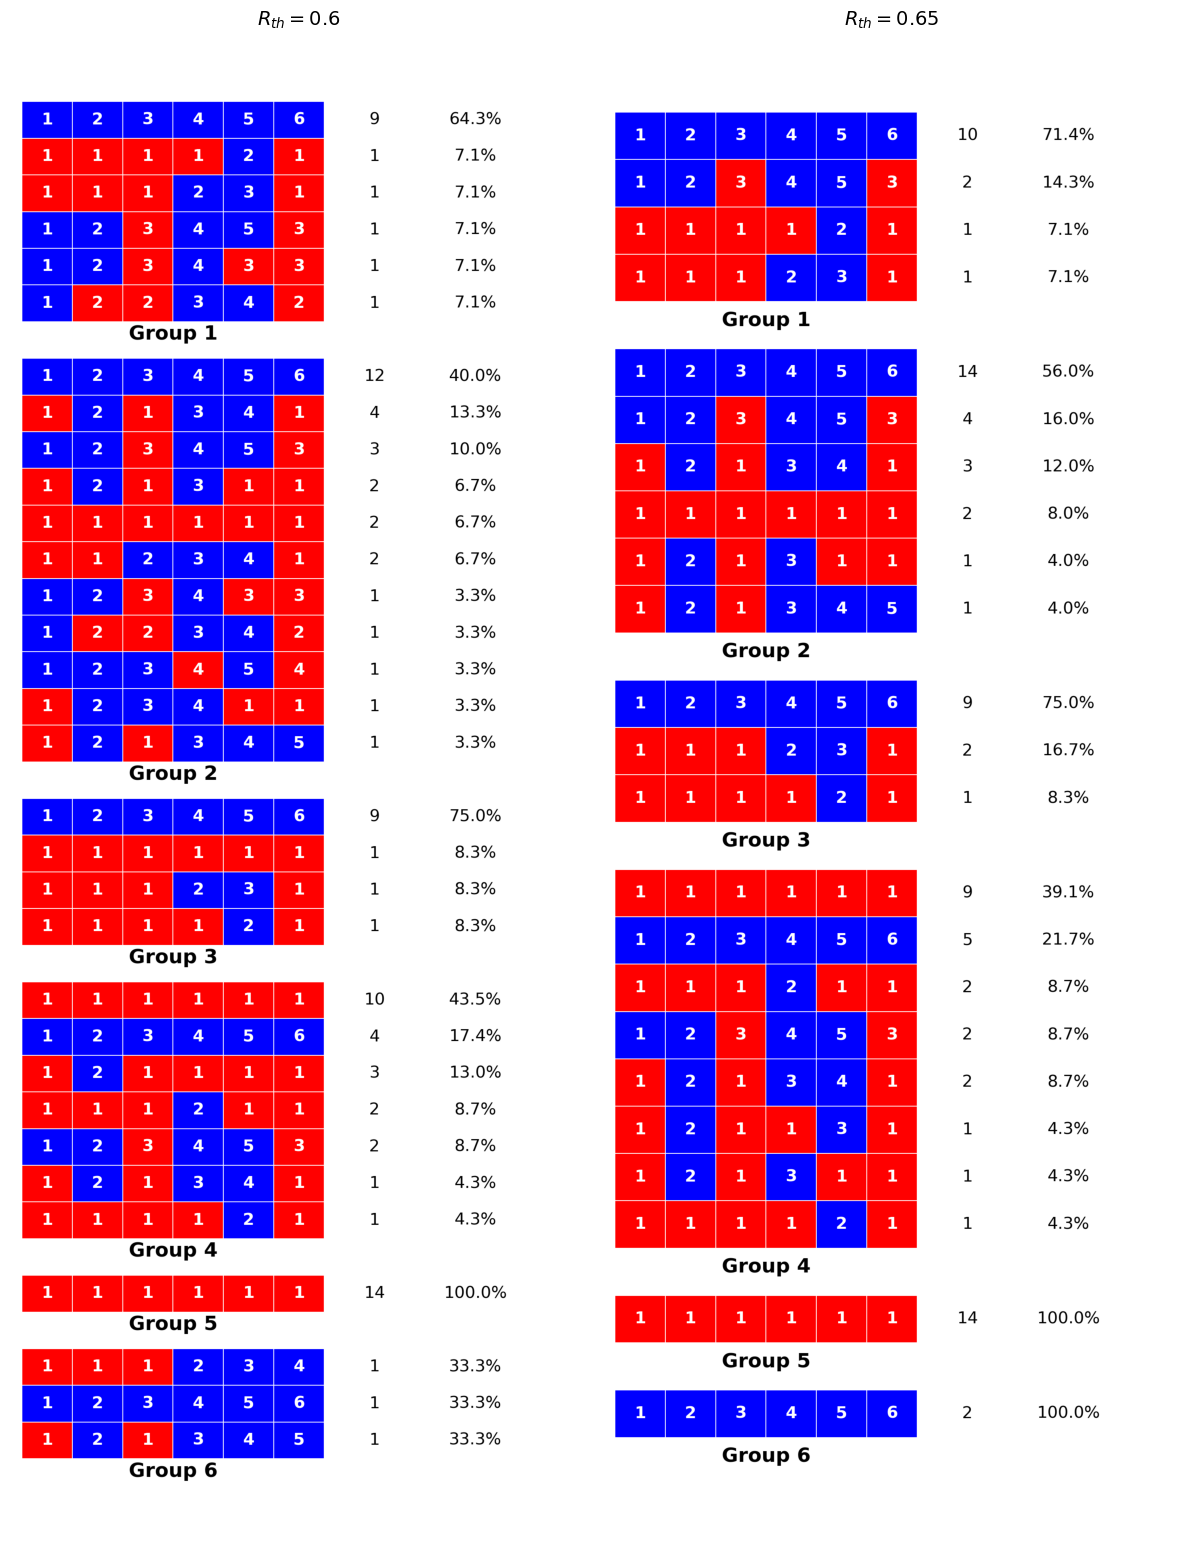

In [9]:
# --- Combine them side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 16))
# Load saved figures as images
img1 = plt.imread("figures/group_palettes_R_th=0.6_unique.png")
img2 = plt.imread("figures/group_palettes_R_th=0.65_unique.png")

axes[0].imshow(img1)
axes[1].imshow(img2)

# Remove axes
for ax in axes:
    ax.axis("off")

# Add labels on top of each subplot
axes[0].set_title(r"$R_{th} = 0.6$", fontsize=14, weight="bold", pad=20)
axes[1].set_title(r"$R_{th} = 0.65$", fontsize=14, weight="bold", pad=20)

plt.tight_layout()
#plt.savefig("figures/group_palettes_R_th=0.6_0.65_unique.pdf", dpi=600, bbox_inches="tight")
plt.show()